In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
#batch-size
B = 50
#epoch
E = 5
#fraction
C=0.1
#learning rate
lr=0.5
#IDD or non-IDD
IDD = False
#num of client
K=100
#num of communication
num_comm=0
#max communication
max_comm=2000
#max accuracy
max_accuracy=0.999
#max round
max_round=20
#decive
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

In [4]:
train_set = datasets.MNIST('../data',train = True, download=False,transform=transform)

test_set = datasets.MNIST('../data', train = False, download = False, transform = transform)


D:\miniconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=B,shuffle=IDD)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=B)

1.造和数据集大小/batchsize 大小的数组  里面标明每个数据属于哪个客户
2.训练时抽K * C 个客户，放在数组里面，对于train的for循环，属于选中客户就进行，不然就continue
3.train里面的w不要更新到原来的w，而是更新到新的数组
4.在一轮循环后，对数组中w加权平均，再更新w

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128,10)
        
    def forward(self, x):
        x = self.conv1(x) #input 1*28*28 output 28-3+1=26 32*26*26
        x = F.relu(x)
        x = self.conv2(x) #input 32*26*26 output 64*24*24
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #input 64*24*24 output 64*12*12
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x) 
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [7]:
model = Net().to(DEVICE)

optimizer = optim.SGD(model.parameters(), lr=lr)
# optimizer = optim.Adadelta(model.parameters(), lr=lr)
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=1, gamma=0.7)



In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_index % 2000 == 0:
            print('Train epoch: {}\t Loss:{:.6f}'.format(epoch,loss.item()))
            
def test(model,device,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()
            pred = output.argmax(dim=1,keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss,100. * correct / len(test_loader.dataset)

In [9]:
# for epoch in range(1,E+1):
#     train(model,DEVICE,train_loader,optimizer,epoch)
#     test(model,DEVICE,test_loader)
# model2 = Net().to(DEVICE)
# model2.load_state_dict(model.state_dict())
# model2.state_dict()

In [10]:
test(model,DEVICE,test_loader)

D:\miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Test set: Average loss: 0.0460, Accuracy: 1270/10000 (13%)



(0.04599446043968201, 12.7)

In [11]:
#将batch分配给各个client,结果存在num_data_eachClient
import random
client_data = []
for i in range(int(len(train_loader.dataset)/B)):
    client_data.append(random.randint(0,K-1))
num_data_eachClient=[0 for i in range(K)]

for i in client_data:
    num_data_eachClient[i]+=1

In [12]:
def client_train(model, device, train_loader, optimizer, localepoch, num_client):
    local_model = Net().to(DEVICE)
    local_model.load_state_dict(model.state_dict())
    optimizer = optim.SGD(local_model.parameters(), lr=lr)
    local_model.train()
    for epoch in range(localepoch):
        for batch_index, (data, target) in enumerate(train_loader):
            if batch_index != num_client:
                continue
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = local_model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
        print('Client{}'.format(num_client),' Train epoch: {}\t Loss:{:.6f}'.format(epoch,loss.item()))
    return local_model.state_dict()
# local_parameters = client_train(model, DEVICE, train_loader, optimizer, E, 0)


Test set: Average loss: 0.0462, Accuracy: 995/10000 (10%)

10 clients trained in  0  round
[27 40 99 57 67 10 97  5 42 91]
Client27  Train epoch: 0	 Loss:2.315482
Client27  Train epoch: 1	 Loss:2.737782
Client27  Train epoch: 2	 Loss:2.314649
Client27  Train epoch: 3	 Loss:2.267085
Client27  Train epoch: 4	 Loss:2.172286
Client40  Train epoch: 0	 Loss:2.323272
Client40  Train epoch: 1	 Loss:2.363559
Client40  Train epoch: 2	 Loss:2.320152
Client40  Train epoch: 3	 Loss:2.262511
Client40  Train epoch: 4	 Loss:2.116321
Client99  Train epoch: 0	 Loss:2.325735
Client99  Train epoch: 1	 Loss:2.059209
Client99  Train epoch: 2	 Loss:2.512133
Client99  Train epoch: 3	 Loss:2.276962
Client99  Train epoch: 4	 Loss:2.185081
Client57  Train epoch: 0	 Loss:2.278516
Client57  Train epoch: 1	 Loss:2.295602
Client57  Train epoch: 2	 Loss:2.206517
Client57  Train epoch: 3	 Loss:1.929544
Client57  Train epoch: 4	 Loss:1.507997
Client67  Train epoch: 0	 Loss:2.285261
Client67  Train epoch: 1	 Loss:2.926

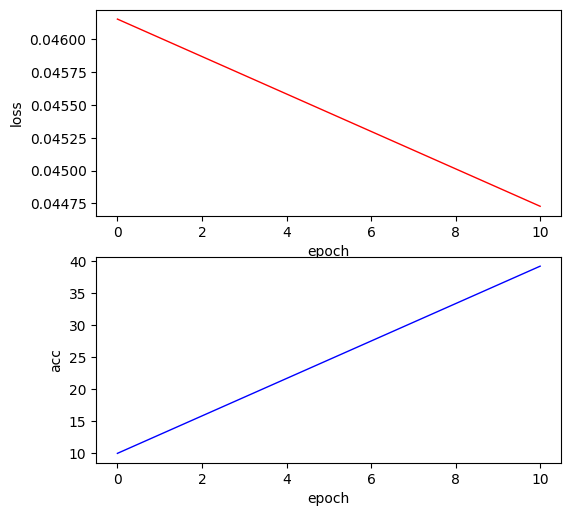

10 clients trained in  1  round
[77 56 17 43 79 73 96 34 66 95]
Client77  Train epoch: 0	 Loss:2.218640
Client77  Train epoch: 1	 Loss:1.855548
Client77  Train epoch: 2	 Loss:1.123853
Client77  Train epoch: 3	 Loss:3.959314
Client77  Train epoch: 4	 Loss:2.273249
Client56  Train epoch: 0	 Loss:2.245260
Client56  Train epoch: 1	 Loss:1.978782
Client56  Train epoch: 2	 Loss:1.587412
Client56  Train epoch: 3	 Loss:2.736397
Client56  Train epoch: 4	 Loss:2.260688
Client17  Train epoch: 0	 Loss:2.240434
Client17  Train epoch: 1	 Loss:2.020772
Client17  Train epoch: 2	 Loss:1.592638
Client17  Train epoch: 3	 Loss:2.537350
Client17  Train epoch: 4	 Loss:2.274169
Client43  Train epoch: 0	 Loss:2.227753
Client43  Train epoch: 1	 Loss:1.809106
Client43  Train epoch: 2	 Loss:1.095487
Client43  Train epoch: 3	 Loss:1.783653
Client43  Train epoch: 4	 Loss:2.298308
Client79  Train epoch: 0	 Loss:2.237197
Client79  Train epoch: 1	 Loss:1.932967
Client79  Train epoch: 2	 Loss:1.413341
Client79  Train 

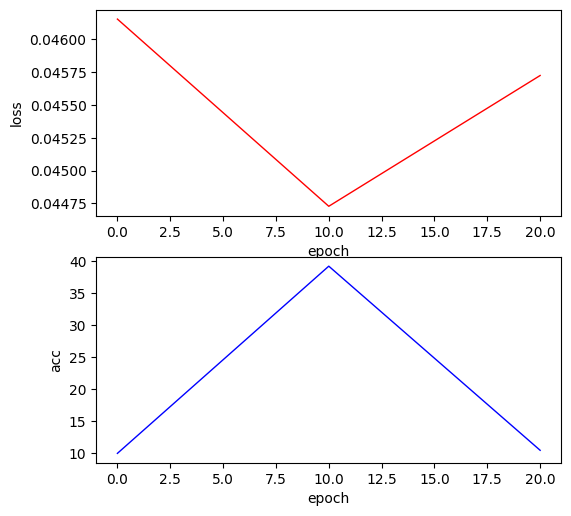

10 clients trained in  2  round
[71 77 16 78 90 84 62 45  9  8]
Client71  Train epoch: 0	 Loss:2.274062
Client71  Train epoch: 1	 Loss:2.169035
Client71  Train epoch: 2	 Loss:1.880103
Client71  Train epoch: 3	 Loss:1.966765
Client71  Train epoch: 4	 Loss:1.855991
Client77  Train epoch: 0	 Loss:2.281340
Client77  Train epoch: 1	 Loss:2.203475
Client77  Train epoch: 2	 Loss:1.904744
Client77  Train epoch: 3	 Loss:1.505963
Client77  Train epoch: 4	 Loss:3.614429
Client16  Train epoch: 0	 Loss:2.285968
Client16  Train epoch: 1	 Loss:2.213237
Client16  Train epoch: 2	 Loss:2.033223
Client16  Train epoch: 3	 Loss:1.575190
Client16  Train epoch: 4	 Loss:3.354450
Client78  Train epoch: 0	 Loss:2.294868
Client78  Train epoch: 1	 Loss:2.241522
Client78  Train epoch: 2	 Loss:2.036203
Client78  Train epoch: 3	 Loss:2.197864
Client78  Train epoch: 4	 Loss:2.172045
Client90  Train epoch: 0	 Loss:2.283490
Client90  Train epoch: 1	 Loss:2.199050
Client90  Train epoch: 2	 Loss:1.953228
Client90  Train 

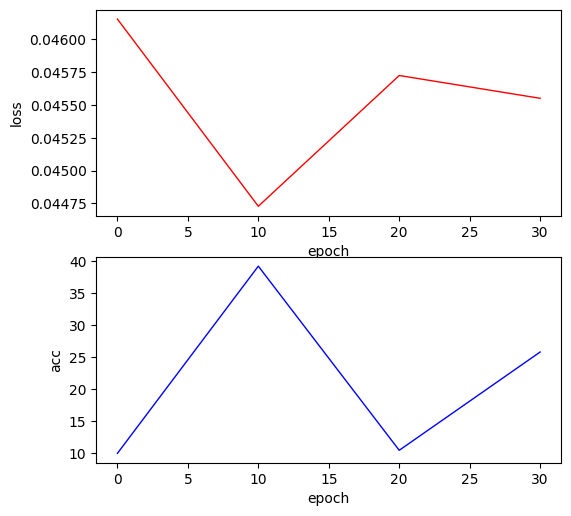

10 clients trained in  3  round
[70 52 86 59 93 53 69 88 43 45]
Client70  Train epoch: 0	 Loss:2.277297
Client70  Train epoch: 1	 Loss:2.196013
Client70  Train epoch: 2	 Loss:2.008853
Client70  Train epoch: 3	 Loss:1.583225
Client70  Train epoch: 4	 Loss:1.306553
Client52  Train epoch: 0	 Loss:2.279172
Client52  Train epoch: 1	 Loss:2.223382
Client52  Train epoch: 2	 Loss:2.091809
Client52  Train epoch: 3	 Loss:1.718893
Client52  Train epoch: 4	 Loss:1.319764
Client86  Train epoch: 0	 Loss:2.284747
Client86  Train epoch: 1	 Loss:2.221219
Client86  Train epoch: 2	 Loss:2.057682
Client86  Train epoch: 3	 Loss:1.761432
Client86  Train epoch: 4	 Loss:1.898974
Client59  Train epoch: 0	 Loss:2.276028
Client59  Train epoch: 1	 Loss:2.182376
Client59  Train epoch: 2	 Loss:1.961223
Client59  Train epoch: 3	 Loss:1.575008
Client59  Train epoch: 4	 Loss:1.528613
Client93  Train epoch: 0	 Loss:2.285805
Client93  Train epoch: 1	 Loss:2.189377
Client93  Train epoch: 2	 Loss:1.974159
Client93  Train 

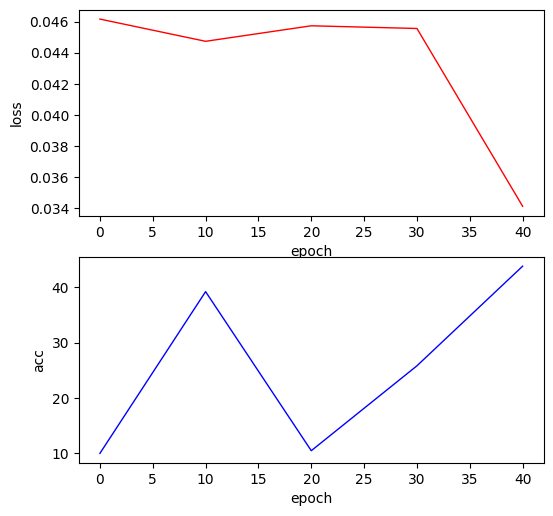

10 clients trained in  4  round
[83 95 62 66 91 27 14 22 47 71]
Client83  Train epoch: 0	 Loss:1.801924
Client83  Train epoch: 1	 Loss:1.169115
Client83  Train epoch: 2	 Loss:1.067117
Client83  Train epoch: 3	 Loss:2.663840
Client83  Train epoch: 4	 Loss:2.246442
Client95  Train epoch: 0	 Loss:1.724623
Client95  Train epoch: 1	 Loss:1.085050
Client95  Train epoch: 2	 Loss:1.708541
Client95  Train epoch: 3	 Loss:1.411650
Client95  Train epoch: 4	 Loss:1.550802
Client62  Train epoch: 0	 Loss:1.583717
Client62  Train epoch: 1	 Loss:1.704207
Client62  Train epoch: 2	 Loss:1.909584
Client62  Train epoch: 3	 Loss:1.591773
Client62  Train epoch: 4	 Loss:1.490416
Client66  Train epoch: 0	 Loss:1.724385
Client66  Train epoch: 1	 Loss:1.658746
Client66  Train epoch: 2	 Loss:1.954537
Client66  Train epoch: 3	 Loss:1.376974
Client66  Train epoch: 4	 Loss:0.971287
Client91  Train epoch: 0	 Loss:1.584183
Client91  Train epoch: 1	 Loss:1.121439
Client91  Train epoch: 2	 Loss:1.451724
Client91  Train 

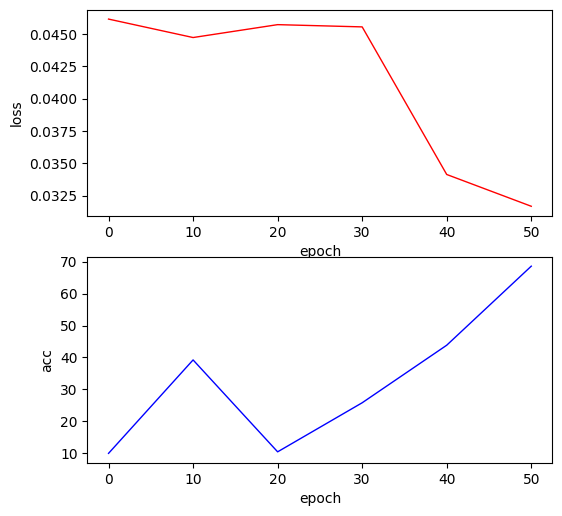

10 clients trained in  5  round
[95 46  4 37 61 83 39 79 54 97]
Client95  Train epoch: 0	 Loss:1.577378
Client95  Train epoch: 1	 Loss:0.918296
Client95  Train epoch: 2	 Loss:1.068357
Client95  Train epoch: 3	 Loss:0.971120
Client95  Train epoch: 4	 Loss:0.941053
Client46  Train epoch: 0	 Loss:1.429867
Client46  Train epoch: 1	 Loss:0.546593
Client46  Train epoch: 2	 Loss:1.346624
Client46  Train epoch: 3	 Loss:1.871762
Client46  Train epoch: 4	 Loss:1.937403
Client4  Train epoch: 0	 Loss:1.536913
Client4  Train epoch: 1	 Loss:0.669391
Client4  Train epoch: 2	 Loss:0.882023
Client4  Train epoch: 3	 Loss:2.799111
Client4  Train epoch: 4	 Loss:2.141430
Client37  Train epoch: 0	 Loss:1.646970
Client37  Train epoch: 1	 Loss:0.749992
Client37  Train epoch: 2	 Loss:0.786970
Client37  Train epoch: 3	 Loss:1.421470
Client37  Train epoch: 4	 Loss:1.140043
Client61  Train epoch: 0	 Loss:1.725982
Client61  Train epoch: 1	 Loss:1.225335
Client61  Train epoch: 2	 Loss:1.724519
Client61  Train epoch

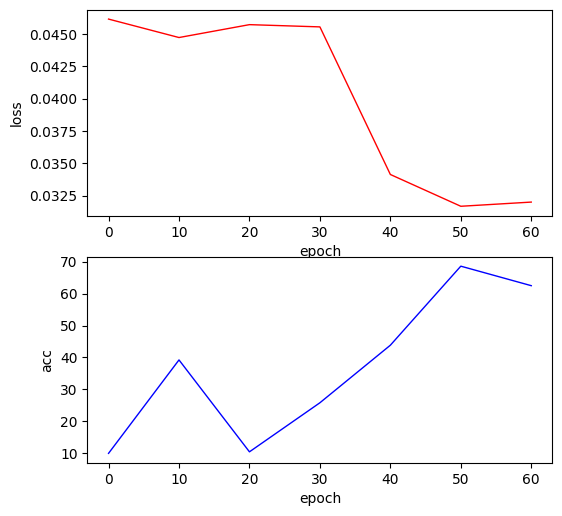

10 clients trained in  6  round
[82 96 83 69 47 46 72 27 90 57]
Client82  Train epoch: 0	 Loss:1.587633
Client82  Train epoch: 1	 Loss:1.200771
Client82  Train epoch: 2	 Loss:1.161170
Client82  Train epoch: 3	 Loss:0.682751
Client82  Train epoch: 4	 Loss:0.603230
Client96  Train epoch: 0	 Loss:1.694204
Client96  Train epoch: 1	 Loss:1.076200
Client96  Train epoch: 2	 Loss:1.086677
Client96  Train epoch: 3	 Loss:0.700742
Client96  Train epoch: 4	 Loss:0.512998
Client83  Train epoch: 0	 Loss:1.538439
Client83  Train epoch: 1	 Loss:0.890565
Client83  Train epoch: 2	 Loss:1.164554
Client83  Train epoch: 3	 Loss:1.049476
Client83  Train epoch: 4	 Loss:0.485523
Client69  Train epoch: 0	 Loss:1.811654
Client69  Train epoch: 1	 Loss:1.320940
Client69  Train epoch: 2	 Loss:1.085818
Client69  Train epoch: 3	 Loss:0.804759
Client69  Train epoch: 4	 Loss:0.382733
Client47  Train epoch: 0	 Loss:1.625842
Client47  Train epoch: 1	 Loss:0.821975
Client47  Train epoch: 2	 Loss:0.593468
Client47  Train 

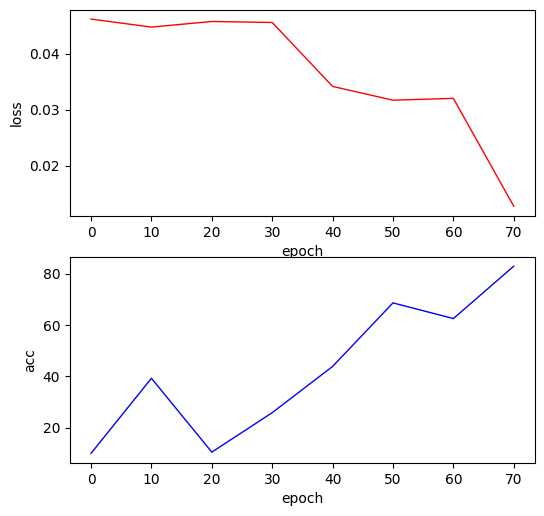

10 clients trained in  7  round
[49 29 83 64 69 18 43 39 56  9]
Client49  Train epoch: 0	 Loss:0.683008
Client49  Train epoch: 1	 Loss:0.288297
Client49  Train epoch: 2	 Loss:1.233064
Client49  Train epoch: 3	 Loss:1.168435
Client49  Train epoch: 4	 Loss:1.118748
Client29  Train epoch: 0	 Loss:0.800585
Client29  Train epoch: 1	 Loss:0.367396
Client29  Train epoch: 2	 Loss:1.002008
Client29  Train epoch: 3	 Loss:1.108746
Client29  Train epoch: 4	 Loss:0.810362
Client83  Train epoch: 0	 Loss:0.636272
Client83  Train epoch: 1	 Loss:0.212933
Client83  Train epoch: 2	 Loss:0.191990
Client83  Train epoch: 3	 Loss:0.141319
Client83  Train epoch: 4	 Loss:0.074335
Client64  Train epoch: 0	 Loss:0.613568
Client64  Train epoch: 1	 Loss:0.374665
Client64  Train epoch: 2	 Loss:0.534981
Client64  Train epoch: 3	 Loss:0.503380
Client64  Train epoch: 4	 Loss:0.415573
Client69  Train epoch: 0	 Loss:0.700640
Client69  Train epoch: 1	 Loss:0.521325
Client69  Train epoch: 2	 Loss:0.378490
Client69  Train 

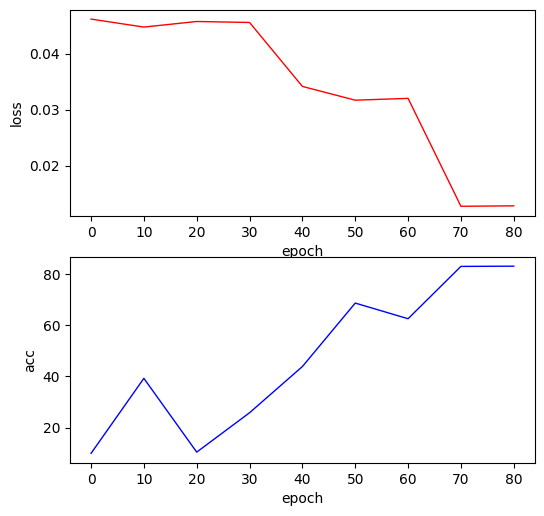

10 clients trained in  8  round
[75 21 43 72  6 77 33 30 16 28]
Client75  Train epoch: 0	 Loss:0.738127
Client75  Train epoch: 1	 Loss:0.404844
Client75  Train epoch: 2	 Loss:0.459796
Client75  Train epoch: 3	 Loss:1.090660
Client75  Train epoch: 4	 Loss:1.478369
Client21  Train epoch: 0	 Loss:0.920110
Client21  Train epoch: 1	 Loss:0.530100
Client21  Train epoch: 2	 Loss:0.672538
Client21  Train epoch: 3	 Loss:0.426337
Client21  Train epoch: 4	 Loss:0.325107
Client43  Train epoch: 0	 Loss:0.468345
Client43  Train epoch: 1	 Loss:0.269607
Client43  Train epoch: 2	 Loss:0.219252
Client43  Train epoch: 3	 Loss:0.697418
Client43  Train epoch: 4	 Loss:0.657536
Client72  Train epoch: 0	 Loss:0.602219
Client72  Train epoch: 1	 Loss:0.260572
Client72  Train epoch: 2	 Loss:0.750975
Client72  Train epoch: 3	 Loss:0.674378
Client72  Train epoch: 4	 Loss:0.485861
Client6  Train epoch: 0	 Loss:0.651420
Client6  Train epoch: 1	 Loss:0.261052
Client6  Train epoch: 2	 Loss:0.286356
Client6  Train epoc

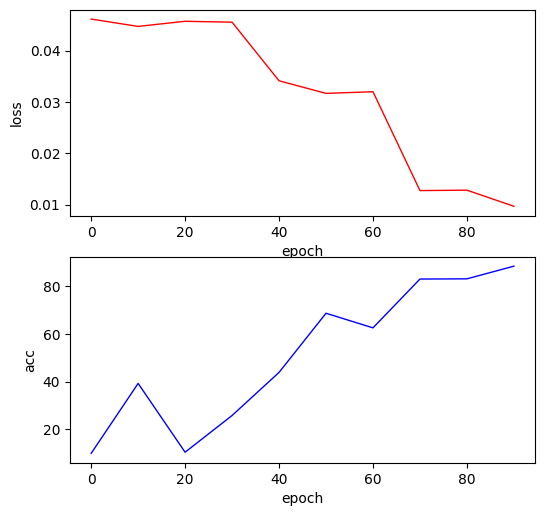

10 clients trained in  9  round
[17 37 89  5  9 33 26 98 87 53]
Client17  Train epoch: 0	 Loss:0.810481
Client17  Train epoch: 1	 Loss:0.473157
Client17  Train epoch: 2	 Loss:0.241427
Client17  Train epoch: 3	 Loss:0.266956
Client17  Train epoch: 4	 Loss:0.218502
Client37  Train epoch: 0	 Loss:0.394264
Client37  Train epoch: 1	 Loss:0.151947
Client37  Train epoch: 2	 Loss:0.101145
Client37  Train epoch: 3	 Loss:0.024006
Client37  Train epoch: 4	 Loss:0.088044
Client89  Train epoch: 0	 Loss:0.682513
Client89  Train epoch: 1	 Loss:0.387815
Client89  Train epoch: 2	 Loss:0.625960
Client89  Train epoch: 3	 Loss:0.363926
Client89  Train epoch: 4	 Loss:0.202819
Client5  Train epoch: 0	 Loss:0.464028
Client5  Train epoch: 1	 Loss:0.337655
Client5  Train epoch: 2	 Loss:0.291696
Client5  Train epoch: 3	 Loss:0.194189
Client5  Train epoch: 4	 Loss:0.247778
Client9  Train epoch: 0	 Loss:0.524383
Client9  Train epoch: 1	 Loss:0.348563
Client9  Train epoch: 2	 Loss:0.368987
Client9  Train epoch: 3	

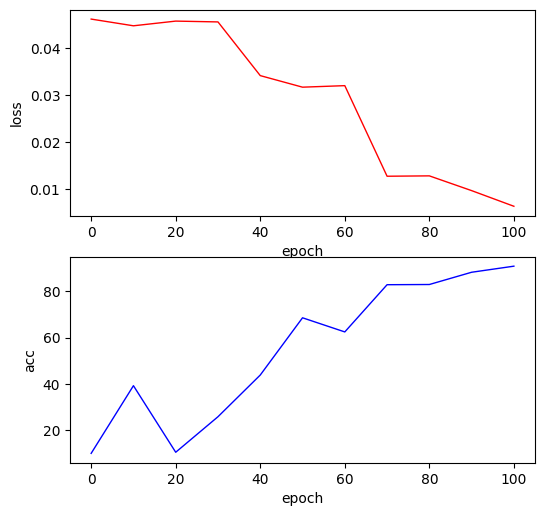

10 clients trained in  10  round
[81 15 13 64  5 10 84 11 63 24]
Client81  Train epoch: 0	 Loss:0.473669
Client81  Train epoch: 1	 Loss:0.130083
Client81  Train epoch: 2	 Loss:0.126962
Client81  Train epoch: 3	 Loss:0.092676
Client81  Train epoch: 4	 Loss:0.089531
Client15  Train epoch: 0	 Loss:0.354441
Client15  Train epoch: 1	 Loss:0.103692
Client15  Train epoch: 2	 Loss:0.155267
Client15  Train epoch: 3	 Loss:0.941911
Client15  Train epoch: 4	 Loss:0.465869
Client13  Train epoch: 0	 Loss:0.396320
Client13  Train epoch: 1	 Loss:0.532053
Client13  Train epoch: 2	 Loss:2.279130
Client13  Train epoch: 3	 Loss:1.415751
Client13  Train epoch: 4	 Loss:1.379225
Client64  Train epoch: 0	 Loss:0.148870
Client64  Train epoch: 1	 Loss:0.085639
Client64  Train epoch: 2	 Loss:0.080398
Client64  Train epoch: 3	 Loss:0.039647
Client64  Train epoch: 4	 Loss:0.037156
Client5  Train epoch: 0	 Loss:0.503586
Client5  Train epoch: 1	 Loss:0.462426
Client5  Train epoch: 2	 Loss:0.538175
Client5  Train epo

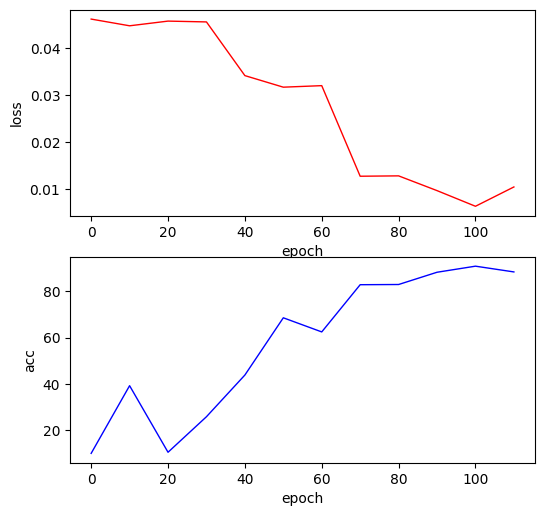

10 clients trained in  11  round
[42 59  9 43 46 64  6 90 38 23]
Client42  Train epoch: 0	 Loss:0.465967
Client42  Train epoch: 1	 Loss:0.063608
Client42  Train epoch: 2	 Loss:0.092594
Client42  Train epoch: 3	 Loss:0.027784
Client42  Train epoch: 4	 Loss:0.068065
Client59  Train epoch: 0	 Loss:0.467803
Client59  Train epoch: 1	 Loss:0.221086
Client59  Train epoch: 2	 Loss:0.171498
Client59  Train epoch: 3	 Loss:0.143367
Client59  Train epoch: 4	 Loss:0.204283
Client9  Train epoch: 0	 Loss:0.503824
Client9  Train epoch: 1	 Loss:0.110831
Client9  Train epoch: 2	 Loss:0.120800
Client9  Train epoch: 3	 Loss:0.143283
Client9  Train epoch: 4	 Loss:0.066932
Client43  Train epoch: 0	 Loss:0.328927
Client43  Train epoch: 1	 Loss:0.185420
Client43  Train epoch: 2	 Loss:0.274973
Client43  Train epoch: 3	 Loss:0.370588
Client43  Train epoch: 4	 Loss:0.142629
Client46  Train epoch: 0	 Loss:0.448626
Client46  Train epoch: 1	 Loss:0.213102
Client46  Train epoch: 2	 Loss:0.121806
Client46  Train epoc

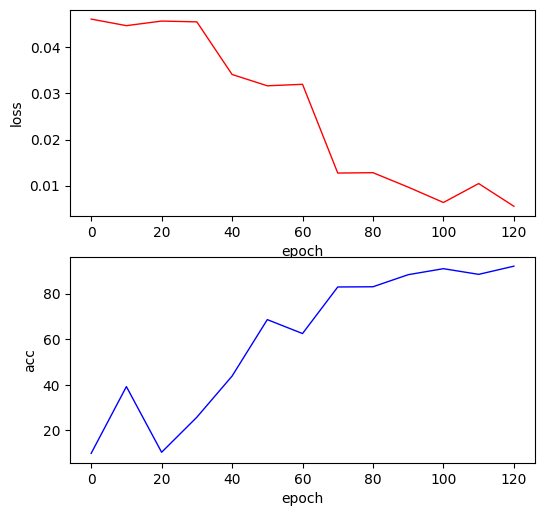

10 clients trained in  12  round
[82 48  4 15  5 23 58 88 81 14]
Client82  Train epoch: 0	 Loss:0.227406
Client82  Train epoch: 1	 Loss:0.117768
Client82  Train epoch: 2	 Loss:0.333026
Client82  Train epoch: 3	 Loss:0.422881
Client82  Train epoch: 4	 Loss:0.660507
Client48  Train epoch: 0	 Loss:0.488025
Client48  Train epoch: 1	 Loss:0.432569
Client48  Train epoch: 2	 Loss:0.312090
Client48  Train epoch: 3	 Loss:0.102463
Client48  Train epoch: 4	 Loss:0.138235
Client4  Train epoch: 0	 Loss:0.289786
Client4  Train epoch: 1	 Loss:0.294498
Client4  Train epoch: 2	 Loss:0.257337
Client4  Train epoch: 3	 Loss:0.180750
Client4  Train epoch: 4	 Loss:0.239950
Client15  Train epoch: 0	 Loss:0.321128
Client15  Train epoch: 1	 Loss:0.263418
Client15  Train epoch: 2	 Loss:0.125651
Client15  Train epoch: 3	 Loss:0.146500
Client15  Train epoch: 4	 Loss:0.110556
Client5  Train epoch: 0	 Loss:0.370410
Client5  Train epoch: 1	 Loss:0.245187
Client5  Train epoch: 2	 Loss:0.145117
Client5  Train epoch: 3

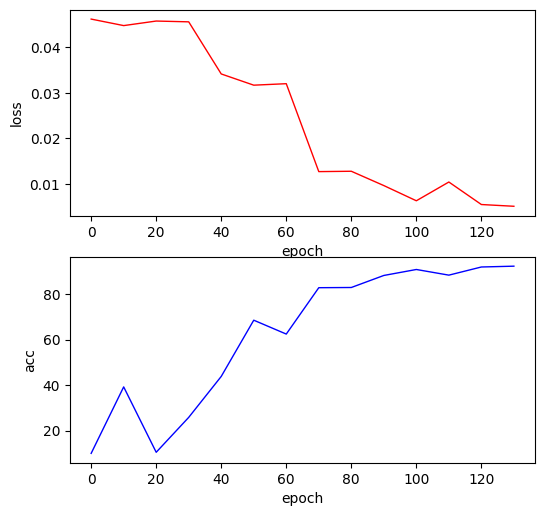

10 clients trained in  13  round
[64 56 50 40 51 18 66 97 24 65]
Client64  Train epoch: 0	 Loss:0.091554
Client64  Train epoch: 1	 Loss:0.063879
Client64  Train epoch: 2	 Loss:0.057287
Client64  Train epoch: 3	 Loss:0.054401
Client64  Train epoch: 4	 Loss:0.052930
Client56  Train epoch: 0	 Loss:0.410380
Client56  Train epoch: 1	 Loss:0.278544
Client56  Train epoch: 2	 Loss:0.287103
Client56  Train epoch: 3	 Loss:0.253476
Client56  Train epoch: 4	 Loss:0.112181
Client50  Train epoch: 0	 Loss:0.132938
Client50  Train epoch: 1	 Loss:0.139245
Client50  Train epoch: 2	 Loss:0.080320
Client50  Train epoch: 3	 Loss:0.057256
Client50  Train epoch: 4	 Loss:0.048779
Client40  Train epoch: 0	 Loss:0.523617
Client40  Train epoch: 1	 Loss:0.298992
Client40  Train epoch: 2	 Loss:0.106731
Client40  Train epoch: 3	 Loss:0.118070
Client40  Train epoch: 4	 Loss:0.101253
Client51  Train epoch: 0	 Loss:0.371375
Client51  Train epoch: 1	 Loss:0.227570
Client51  Train epoch: 2	 Loss:0.107167
Client51  Train

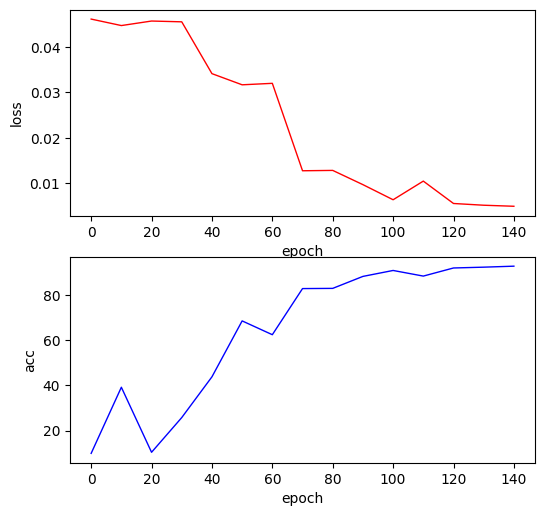

10 clients trained in  14  round
[62 26  5 60 25 65 17 33  9 15]
Client62  Train epoch: 0	 Loss:0.142090
Client62  Train epoch: 1	 Loss:0.127919
Client62  Train epoch: 2	 Loss:0.268114
Client62  Train epoch: 3	 Loss:0.208446
Client62  Train epoch: 4	 Loss:0.096495
Client26  Train epoch: 0	 Loss:0.189287
Client26  Train epoch: 1	 Loss:0.276697
Client26  Train epoch: 2	 Loss:0.221987
Client26  Train epoch: 3	 Loss:0.242999
Client26  Train epoch: 4	 Loss:0.235495
Client5  Train epoch: 0	 Loss:0.200250
Client5  Train epoch: 1	 Loss:0.138550
Client5  Train epoch: 2	 Loss:0.073240
Client5  Train epoch: 3	 Loss:0.050439
Client5  Train epoch: 4	 Loss:0.064965
Client60  Train epoch: 0	 Loss:0.304577
Client60  Train epoch: 1	 Loss:0.265236
Client60  Train epoch: 2	 Loss:0.141926
Client60  Train epoch: 3	 Loss:0.166635
Client60  Train epoch: 4	 Loss:0.176377
Client25  Train epoch: 0	 Loss:0.323283
Client25  Train epoch: 1	 Loss:0.249917
Client25  Train epoch: 2	 Loss:0.147184
Client25  Train epoc

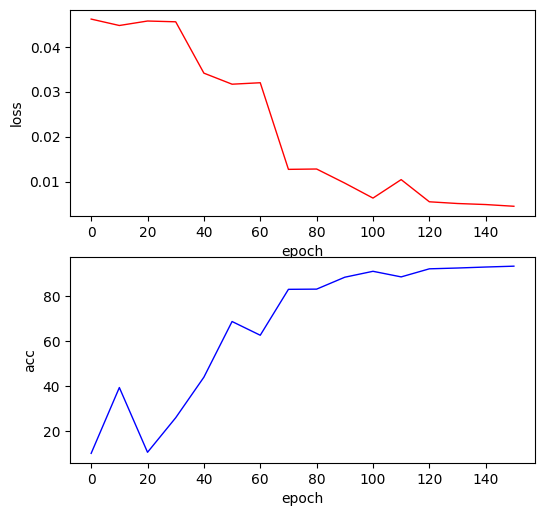

10 clients trained in  15  round
[ 7 73 78 43 28 34 46 49 36 61]
Client7  Train epoch: 0	 Loss:0.085237
Client7  Train epoch: 1	 Loss:0.157031
Client7  Train epoch: 2	 Loss:0.036750
Client7  Train epoch: 3	 Loss:0.010128
Client7  Train epoch: 4	 Loss:0.008616
Client73  Train epoch: 0	 Loss:0.377934
Client73  Train epoch: 1	 Loss:0.222799
Client73  Train epoch: 2	 Loss:0.032565
Client73  Train epoch: 3	 Loss:0.131912
Client73  Train epoch: 4	 Loss:0.123220
Client78  Train epoch: 0	 Loss:0.259731
Client78  Train epoch: 1	 Loss:0.301257
Client78  Train epoch: 2	 Loss:0.255791
Client78  Train epoch: 3	 Loss:0.068540
Client78  Train epoch: 4	 Loss:0.110191
Client43  Train epoch: 0	 Loss:0.120747
Client43  Train epoch: 1	 Loss:0.138917
Client43  Train epoch: 2	 Loss:0.110961
Client43  Train epoch: 3	 Loss:0.160868
Client43  Train epoch: 4	 Loss:0.048905
Client28  Train epoch: 0	 Loss:0.363804
Client28  Train epoch: 1	 Loss:0.520905
Client28  Train epoch: 2	 Loss:0.465592
Client28  Train epoc

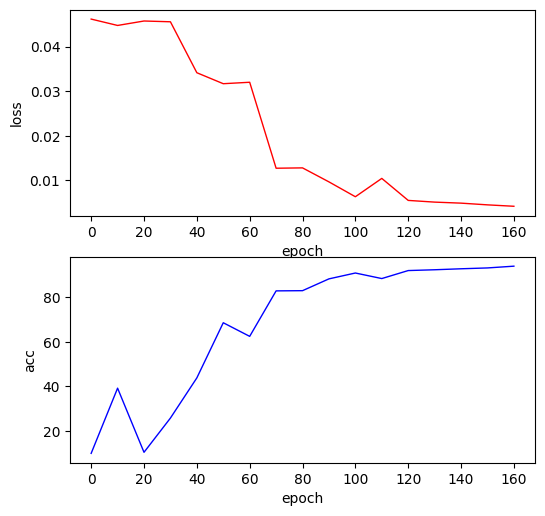

10 clients trained in  16  round
[57 67  8 54 56 47 78 34 60 22]
Client57  Train epoch: 0	 Loss:0.079937
Client57  Train epoch: 1	 Loss:0.020234
Client57  Train epoch: 2	 Loss:0.055793
Client57  Train epoch: 3	 Loss:0.057249
Client57  Train epoch: 4	 Loss:0.013258
Client67  Train epoch: 0	 Loss:0.304026
Client67  Train epoch: 1	 Loss:0.112949
Client67  Train epoch: 2	 Loss:0.138483
Client67  Train epoch: 3	 Loss:0.099039
Client67  Train epoch: 4	 Loss:0.106796
Client8  Train epoch: 0	 Loss:0.281694
Client8  Train epoch: 1	 Loss:0.270470
Client8  Train epoch: 2	 Loss:0.178629
Client8  Train epoch: 3	 Loss:0.095812
Client8  Train epoch: 4	 Loss:0.076265
Client54  Train epoch: 0	 Loss:0.355831
Client54  Train epoch: 1	 Loss:0.361552
Client54  Train epoch: 2	 Loss:0.242999
Client54  Train epoch: 3	 Loss:0.246073
Client54  Train epoch: 4	 Loss:0.079873
Client56  Train epoch: 0	 Loss:0.308805
Client56  Train epoch: 1	 Loss:0.063378
Client56  Train epoch: 2	 Loss:0.078059
Client56  Train epoc

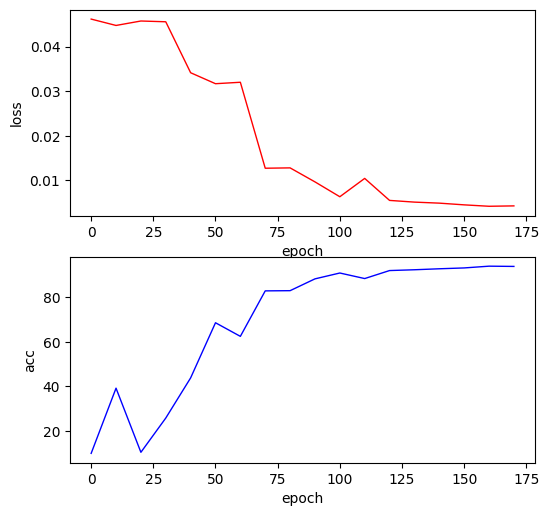

10 clients trained in  17  round
[ 7 60 85 64 21 19 68 74 30 48]
Client7  Train epoch: 0	 Loss:0.111223
Client7  Train epoch: 1	 Loss:0.165303
Client7  Train epoch: 2	 Loss:0.262570
Client7  Train epoch: 3	 Loss:0.076311
Client7  Train epoch: 4	 Loss:0.156439
Client60  Train epoch: 0	 Loss:0.095108
Client60  Train epoch: 1	 Loss:0.086821
Client60  Train epoch: 2	 Loss:0.053689
Client60  Train epoch: 3	 Loss:0.044945
Client60  Train epoch: 4	 Loss:0.030331
Client85  Train epoch: 0	 Loss:0.535983
Client85  Train epoch: 1	 Loss:0.337083
Client85  Train epoch: 2	 Loss:0.353507
Client85  Train epoch: 3	 Loss:0.443939
Client85  Train epoch: 4	 Loss:0.728779
Client64  Train epoch: 0	 Loss:0.162493
Client64  Train epoch: 1	 Loss:0.048681
Client64  Train epoch: 2	 Loss:0.019904
Client64  Train epoch: 3	 Loss:0.012447
Client64  Train epoch: 4	 Loss:0.006547
Client21  Train epoch: 0	 Loss:0.612763
Client21  Train epoch: 1	 Loss:0.313173
Client21  Train epoch: 2	 Loss:0.134528
Client21  Train epoc

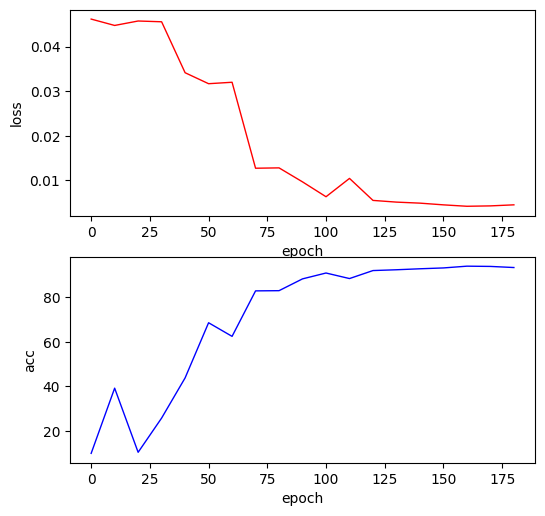

10 clients trained in  18  round
[79 24 15 85 89  5 35 29 93 94]
Client79  Train epoch: 0	 Loss:0.310320
Client79  Train epoch: 1	 Loss:0.116474
Client79  Train epoch: 2	 Loss:0.114426
Client79  Train epoch: 3	 Loss:0.064260
Client79  Train epoch: 4	 Loss:0.048928
Client24  Train epoch: 0	 Loss:0.494196
Client24  Train epoch: 1	 Loss:0.356373
Client24  Train epoch: 2	 Loss:0.259156
Client24  Train epoch: 3	 Loss:0.255637
Client24  Train epoch: 4	 Loss:0.692848
Client15  Train epoch: 0	 Loss:0.177721
Client15  Train epoch: 1	 Loss:0.072453
Client15  Train epoch: 2	 Loss:0.030608
Client15  Train epoch: 3	 Loss:0.085914
Client15  Train epoch: 4	 Loss:0.018999
Client85  Train epoch: 0	 Loss:0.316180
Client85  Train epoch: 1	 Loss:0.213692
Client85  Train epoch: 2	 Loss:0.065891
Client85  Train epoch: 3	 Loss:0.037688
Client85  Train epoch: 4	 Loss:0.039632
Client89  Train epoch: 0	 Loss:0.351124
Client89  Train epoch: 1	 Loss:0.177159
Client89  Train epoch: 2	 Loss:0.161965
Client89  Train

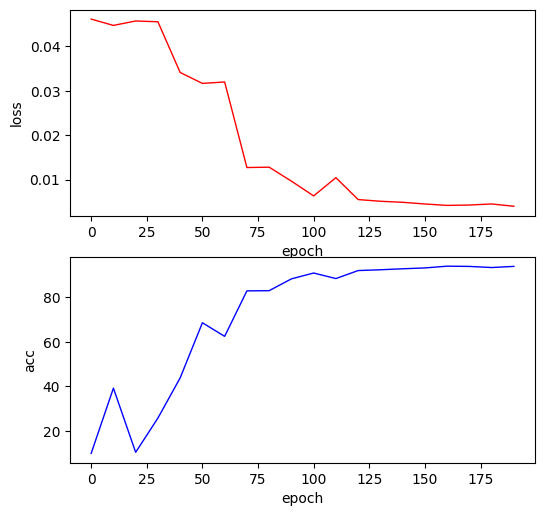

10 clients trained in  19  round
[ 7 20 41 89 93 47 38 12 33 70]
Client7  Train epoch: 0	 Loss:0.135554
Client7  Train epoch: 1	 Loss:0.137627
Client7  Train epoch: 2	 Loss:0.115085
Client7  Train epoch: 3	 Loss:0.164783
Client7  Train epoch: 4	 Loss:0.089043
Client20  Train epoch: 0	 Loss:0.433559
Client20  Train epoch: 1	 Loss:0.270174
Client20  Train epoch: 2	 Loss:0.297733
Client20  Train epoch: 3	 Loss:0.081750
Client20  Train epoch: 4	 Loss:0.091841
Client41  Train epoch: 0	 Loss:0.624558
Client41  Train epoch: 1	 Loss:0.290609
Client41  Train epoch: 2	 Loss:0.088359
Client41  Train epoch: 3	 Loss:0.114619
Client41  Train epoch: 4	 Loss:0.078256
Client89  Train epoch: 0	 Loss:0.194664
Client89  Train epoch: 1	 Loss:0.108783
Client89  Train epoch: 2	 Loss:0.101938
Client89  Train epoch: 3	 Loss:0.086917
Client89  Train epoch: 4	 Loss:0.128123
Client93  Train epoch: 0	 Loss:0.142958
Client93  Train epoch: 1	 Loss:0.134878
Client93  Train epoch: 2	 Loss:0.159290
Client93  Train epoc

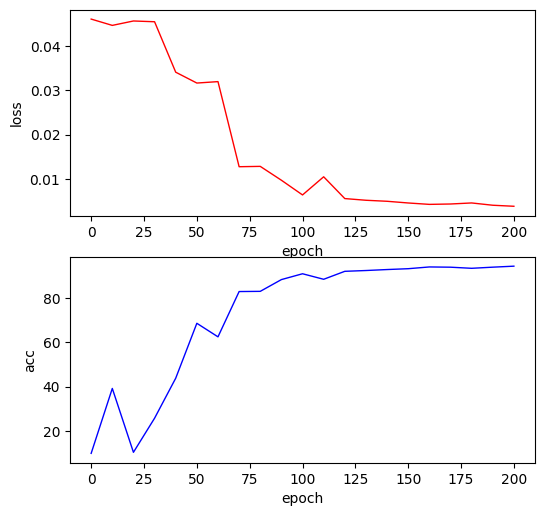

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def selectClient(m,K):#K 个客户选 m个客户出来训练
    arr = np.random.permutation(K)
    return arr[0:m]
def server_train(model, device, train_loader, optimizer, localepoch, fraction_train_client):
    list_loss = []
    list_accracy = []
    list_comm = []
    num_comm = 0
    globalmodel = Net().to(device)
    res = test(globalmodel,DEVICE,test_loader)#测试集上loss和准确率
    list_loss.append(res[0])
    list_accracy.append(res[1])
    list_comm.append(num_comm)
    for round in range(max_round):
        m = max(int(C*K),1)
        print(m,"clients trained in ",round," round")
        client_arr = selectClient(m,K)
        print(client_arr)
        num_total_data = 0
        new_parameters = None#声明新参数
        for i in range(len(client_arr)):
            num_total_data+=num_data_eachClient[i]
        for i in range(len(client_arr)):#对第k个客户进行训练
            local_parameters = client_train(globalmodel, DEVICE, train_loader, optimizer, E, client_arr[i])
            if new_parameters is None:#将第k个客户w加权更新到新new_parameters中
                new_parameters = {}
                for key, var in local_parameters.items():
                    new_parameters[key] = (num_data_eachClient[i]/num_total_data) * var.clone()
            else:
                for var in new_parameters:
                    new_parameters[var] = new_parameters[var] +  (num_data_eachClient[i]/num_total_data) * local_parameters[var]
            num_comm+=1
        globalmodel.load_state_dict(new_parameters)
        res = test(globalmodel,DEVICE,test_loader)#测试集上loss和准确率
        list_loss.append(res[0])
        list_accracy.append(res[1])
        list_comm.append(num_comm)
        
        
        plt.figure(figsize=(6, 6), dpi=100)
        # 创建两行一列的图，并指定当前使用第一个图
        plt.subplot(2, 1, 1)
        try:
            train_loss_lines.remove(train_loss_lines[0])  # 移除上一步曲线
            val_loss_lines.remove(val_loss_lines[0])
        except Exception:
            pass

        train_loss_lines = plt.plot(list_comm, list_loss, 'r', lw=1)  # lw为曲线宽度
        plt.xlabel("epoch")
        plt.ylabel("loss")

        # # 创建两行一列的图，并指定当前使用第二个图
        plt.subplot(2, 1, 2)
        try:
            train_acc_lines.remove(train_acc_lines[0])  # 移除上一步曲线
            val_acc_lines.remove(val_acc_lines[0])
        except Exception:
            pass

        train_acc_lines = plt.plot(list_comm, list_accracy, 'b', lw=1)  # lw为曲线宽度
        plt.xlabel("epoch")
        plt.ylabel("acc")

        plt.show()
server_train(model, DEVICE, train_loader, optimizer, E, C)
